# User-defined Attribute Types

**Purpose**: demonstrate using `dj.AttributeAdapter` for convenient storage of arbitrary data types in DataJoint table attributes.

Imagine I want store graph objects of type `networkx.Graph` in the form of edge lists. 

First, let's create a few graphs:

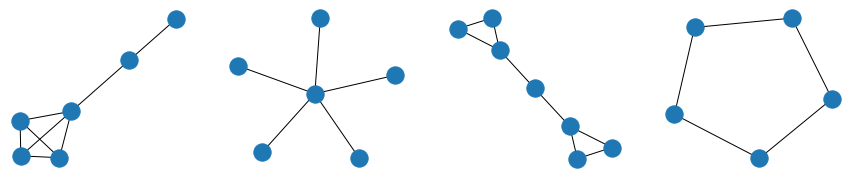

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
graphs = [nx.lollipop_graph(4, 2), nx.star_graph(5), nx.barbell_graph(3, 1), nx.cycle_graph(5)]

fig, axx = plt.subplots(1, len(graphs) , figsize=(15, 3))
for g, ax in zip(graphs, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)

Then we need to define an adapter object that convert target objects into an attribute type that datajoint can already store. The class must subclass `dj.AttributeAdapter` and define the property `attribute_type`, and methods `get` 

In [2]:
import datajoint as dj

class GraphAdapter(dj.AttributeAdapter):
    
    attribute_type = 'longblob'   # this is how the attribute will be declared
    
    def get(self, obj):
        return nx.Graph(obj)
    
    def put(self, obj):
        # convert graph object into an edgelist
        assert isinstance(obj, nx.Graph)
        return list(obj.edges)

# instantiate for use as a datajoint type
graph = GraphAdapter()

Now we can define a table that uses `graph` as its attribute type. These "adapted types" must be enclosed in angle brackets as in `<graph>`:

In [3]:
schema = dj.schema('test_graphs')

Connecting dimitri@localhost:3306


In [4]:
@schema
class Connectivity(dj.Manual):
    definition = """
    cid : int
    ---
    connectivity : <graph>  # a networkx.Graph object 
    """
    

In [5]:
Connectivity.insert((i, g) for i, g in enumerate(graphs))

In [6]:
Connectivity()

cid,connectivity a networkx.Graph object
0,=BLOB=
1,=BLOB=
2,=BLOB=
3,=BLOB=


In [7]:
g = Connectivity.fetch('connectivity')

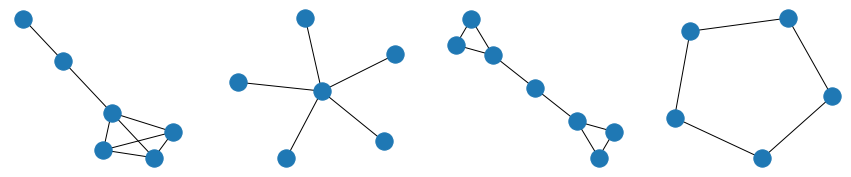

In [8]:
fig, axx = plt.subplots(1, len(graphs) , figsize=(15, 3))
for g, ax in zip(graphs, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)

As another example, let's pack a positive fraction as a single uint64 number

In [9]:
from fractions import Fraction

In [10]:
a = Fraction(3,7) / Fraction(2,8)
a

Fraction(12, 7)

In [11]:
a.denominator

7

In [ ]:
class FractionAdapter(dj.AttributeAdapter):
    
    attribute_type = 'bigint unsigned'
    
    @staticmethod
    def put(fraction):
        assert isinstance(fraction, Fraction)
        assert 0 <= fraction.denominator < (1 << 32)-1 
        assert 0 <= fraction.numerator < (1 << 32)-1 
        return (fraction.numerator << 32) + fraction.denominator
    
    @staticmethod
    def get(uint64):
        return Fraction(uint64 >> 32, uint64 % (1 << 32))
    
frac = FractionAdapter()
        
        
        

In [ ]:
@schema 
class Frac(dj.Manual):
    definition = """
    frac : <frac>    
    """

In [ ]:
Frac.insert1([Fraction(1,3)])
Frac.insert1([Fraction(2,3)])

In [ ]:
Frac.fetch(as_dict=True)